## Cheking pre-requisites

In [1]:
%store -r setup_dependencies_passed

try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")


print(setup_dependencies_passed)

True


In [7]:
%store -r setup_s3_bucket_passed
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")


print(setup_s3_bucket_passed)

True


In [10]:
%store -r setup_iam_roles_passed


try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

print(setup_iam_roles_passed)

True


In [11]:
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

### Import the necessary packages and initialize sagemaker, bucket and role

In [12]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### Copy the public dataset Amazon Reviews to our local sagemaker

In [13]:
!aws s3 cp 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [14]:
import csv

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df.shape

(102084, 15)

In [15]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

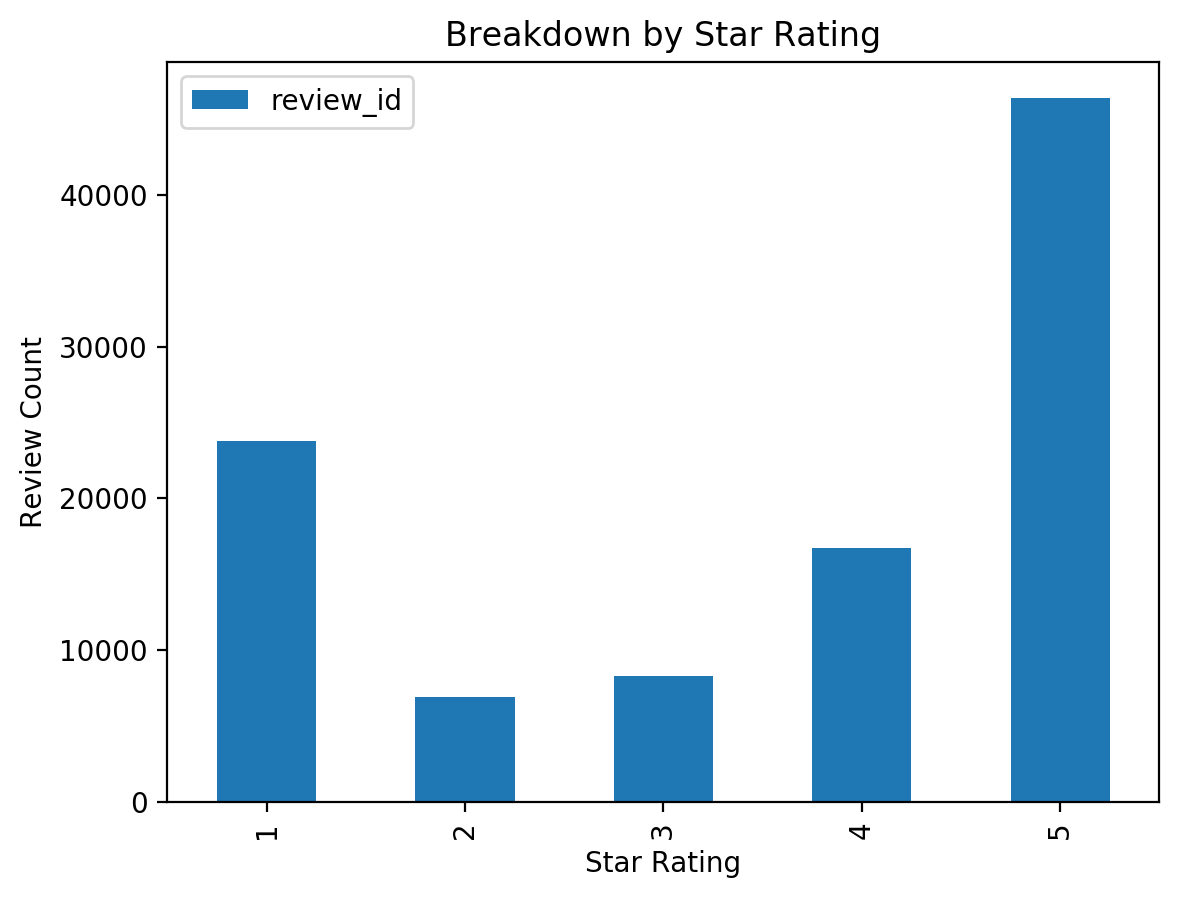

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

### Balance the dataset

In [19]:
print("Shape of dataframe before splitting {}".format(df.shape))

Shape of dataframe before splitting (102084, 15)


In [20]:
# Balance the dataset down to the minority class
df_grouped_by = df.groupby(["star_rating"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (34450, 15)


In [26]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,38897058,R30AFBQYJRDSKL,B00E7X8YK4,713752890,Quicken Home & Business 2,Digital_Software,1,0,0,N,N,HATE HATE HATE 2014,*A*a*a*r*g*h*!*!*!*<br />I have been using Qui...,2014-07-04
1,US,10557370,R9F84336RNYYT,B00MV9W88A,725945680,McAfee Total Protection 3PC 2014 [Online Code],Digital_Software,1,0,0,N,Y,Had a huge problem with installment. Took 4 da...,Had a huge problem with installment. Took 4 da...,2014-10-24
2,US,28808007,R1H83968DQ3NM8,B00NG7JXH0,129292107,TurboTax Deluxe Fed + Efile + State,Digital_Software,1,1,1,N,N,INTUIT running for cover,"Intuit trying to make amends - too little, too...",2015-01-29
3,US,34455801,RHDAY361OS39O,B009KRW8JK,908246000,Bitdefender Antivirus Plus 2013 (3PC/1YR) [Dow...,Digital_Software,1,22,26,N,N,HORRIBLE,"The amount of hours I have spent, doing what c...",2013-03-07
4,US,24118990,R8FD1MYMTUB0F,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],Digital_Software,1,0,0,N,Y,DON'T BUY THIS ANTIVIRUS!,I recently got a new laptop with windows 8 and...,2015-07-08


### Write a csv with the balanced dataset

In [30]:
autopilot_train_path = "./amazon_reviews_us_Digital_Software_v1_00_autopilot.csv"
df_balanced.to_csv(autopilot_train_path, index=False, header=True)

### Upload to s3

In [31]:
train_s3_prefix = "data"
autopilot_train_s3_uri = sess.upload_data(path=autopilot_train_path, key_prefix=train_s3_prefix)
autopilot_train_s3_uri

's3://sagemaker-eu-west-3-553453044463/data/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv'

### Free Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}
